# Final report for Spire consulting project

In [1]:
import psycopg2
import supportfun
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime, date, time
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import cross_validation, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

/Users/Xin/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Xin/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# connect to database
user = 'Xin' #add your username here (same as previous postgreSQL)                      
host = 'localhost'
dbname = 'spire_user'
con = None
con = psycopg2.connect(database = dbname, user = user)

In [3]:
# load user data from database
userid = 5
# query
sql_query = "SELECT * FROM user_data as ud INNER JOIN user_id as ui ON ud.md5 = ui.md5 WHERE ui.index = %i;" %(userid)
data_from_sql = pd.read_sql_query(sql_query,con)

In [9]:
df_short = data_from_sql.iloc[:,[0, 2, 5, 6, 8, 9, 10, 11, 12, -3, -5, -6, -7]]
hour = supportfun.hours(df_short)
df_short["hours"] = hour

/Users/Xin/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [10]:
#df_short_cut = df_short[df_short.streak_type != "inactive"] 
df_short_cut = df_short
df_short_cut.streak_type = df_short_cut.streak_type.astype(float)

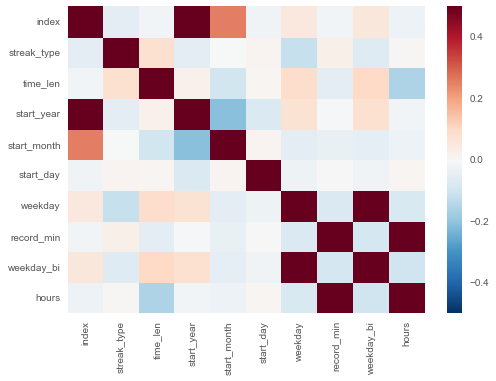

In [11]:
corrmat = df_short_cut.corr()
g = sns.heatmap(corrmat, vmax = 0.5)
plt.show()

In [12]:
df_tmp = df_short_cut.groupby(["start_ymd","hours","streak_type", "time_len"])
df_freq = df_tmp.sum() # a new feature "time_len" - seconds in an hour; "hours" - 0-24 hour per day
df_freq = df_freq.reset_index()
df_tmp1 = df_freq.groupby(["start_ymd","hours","streak_type"]).sum()
df_freq = df_tmp1.reset_index()
df_freq = df_freq.iloc[:, [0, 1, 2, 3]]

In [13]:
year = {}
month = {}
day = {}
weekday = {}
for i in range(len(df_freq.start_ymd)):
    dt = datetime.strptime(df_freq.start_ymd[i], "%Y-%m-%d")
    year[i] = dt.year
    month[i] = dt.month
    day[i] = dt.day
    weekday[i] = dt.weekday()
df_freq['year'] = year.values()
df_freq['month'] = month.values()
df_freq['day'] = day.values()
df_freq['weekday'] = weekday.values() # monday is 0, sunday is 6

In [14]:
df_hourly = df_freq.groupby(["hours", "streak_type"]).mean().reset_index()
type_ratio = df_hourly.time_len/3600
df_hourly = df_hourly.iloc[:, 0:2]
df_hourly["type_ratio"] = type_ratio

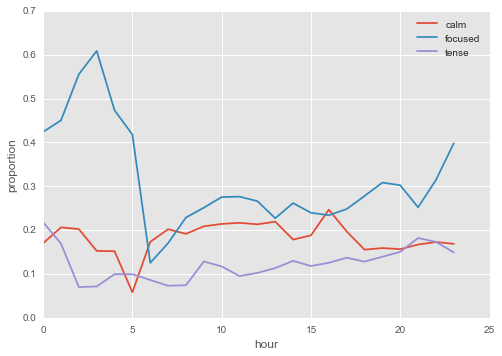

In [15]:
plt.plot(df_hourly[df_hourly.streak_type == 0].hours, df_hourly[df_hourly.streak_type == 0].type_ratio, label = "calm")
plt.plot(df_hourly[df_hourly.streak_type == 1].hours, df_hourly[df_hourly.streak_type == 1].type_ratio, label = "focused")
plt.plot(df_hourly[df_hourly.streak_type == 2].hours, df_hourly[df_hourly.streak_type == 2].type_ratio, label = "tense")
plt.xlabel("hour")
plt.ylabel("proportion")
plt.legend()
plt.show()

In [16]:
df_freq_long = df_freq.merge(df_hourly, how = "left", left_on = ["hours", "streak_type"], right_on = ["hours", "streak_type"])
df_freq_long.head()

,start_ymd,hours,streak_type,time_len,year,month,day,weekday,type_ratio
0,2014-12-21,8,0.0,1264.0,2014,12,21,6,0.191441
1,2014-12-21,9,0.0,540.0,2014,12,21,6,0.208692
2,2014-12-21,9,2.0,422.0,2014,12,21,6,0.128417
3,2014-12-21,10,0.0,541.0,2014,12,21,6,0.214119
4,2014-12-21,14,0.0,483.0,2014,12,21,6,0.178397


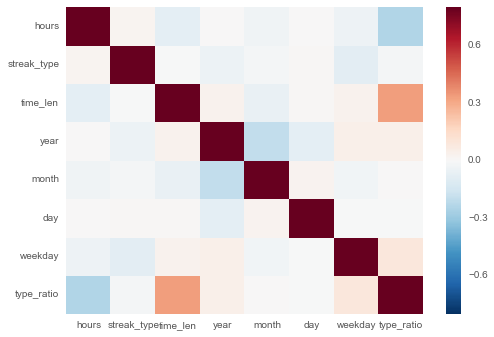

In [17]:
corrmat = df_freq_long.corr()
g = sns.heatmap(corrmat, vmax = 0.8)
plt.show()

In [18]:
# to check the feature importance before do onehotencode
X = df_freq_long.iloc[:,[1, 5, 6, 7, 8]].values
y = df_freq_long['streak_type'].values
X = scale(X)

In [19]:
supportfun.classfication(RandomForestClassifier(), 5, True, X, y)

[ 0.0429069   0.0053277   0.00727278  0.00580396  0.93868866]
[0.99759384023099129, 0.99903753609239654, 0.99807507218479308, 0.99663137632338783, 1.0]
accurancy:  0.998 0.001 

confusion_matrix:  [[ 1.     0.     0.   ]
 [ 0.001  0.998  0.001]
 [ 0.004  0.     0.996]] 



In [20]:
supportfun.classfication(AdaBoostClassifier(), 5, True, X, y)

[ 0.54  0.    0.    0.    0.46]
[0.59239653512993262, 0.90471607314725699, 0.96053897978825797, 0.58710298363811353, 0.95524542829643888]
accurancy:  0.8 0.173 

confusion_matrix:  [[ 0.958  0.042  0.   ]
 [ 0.398  0.602  0.   ]
 [ 0.098  0.     0.902]] 



In [21]:
supportfun.classfication(GradientBoostingClassifier(), 5, True, X, y)

[ 0.14432925  0.          0.          0.          0.85567075]
[1.0, 1.0, 1.0, 0.99903753609239654, 1.0]
accurancy:  1.0 0.0 

confusion_matrix:  [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]] 



In [22]:
supportfun.classfication(DecisionTreeClassifier(), 5, True, X, y)

[ 0.01272935  0.          0.          0.          0.98727065]
[1.0, 1.0, 1.0, 0.99903753609239654, 0.99951876804619821]
accurancy:  1.0 0.0 

confusion_matrix:  [[ 1.     0.     0.   ]
 [ 0.     1.     0.   ]
 [ 0.     0.001  0.999]] 



In [23]:
supportfun.classfication(ExtraTreesClassifier(), 5, True, X, y)

[ 0.08805303  0.00936304  0.01151479  0.00778043  0.8832887 ]
[0.98363811357074105, 0.99711260827718962, 0.99374398460057745, 0.99711260827718962, 0.99807507218479308]
accurancy:  0.994 0.005 

confusion_matrix:  [[ 0.998  0.001  0.001]
 [ 0.003  0.996  0.   ]
 [ 0.023  0.001  0.976]] 



In [24]:
# use as categorical data 
X = df_freq_long.iloc[:,[1, 5, 6, 7]].values
y = df_freq_long['streak_type'].values
enc = OneHotEncoder()
enc.fit(X)
X_enc = enc.transform(X).toarray()
X_enc.shape
X8 = df_freq_long.iloc[:,8]
X8 = X8.values
X8 = X8.reshape(len(X8), 1)
X = np.concatenate([X_enc, X8], axis = 1)

In [25]:
supportfun.classfication(linear_model.LogisticRegression(), 5, False, X, y)

[0.8089509143407122, 0.78488931665062556, 0.84359961501443692, 0.82771896053897975, 0.85611164581328203]
accurancy:  0.824 0.025 

confusion_matrix:  [[ 0.87   0.126  0.004]
 [ 0.048  0.952  0.   ]
 [ 0.659  0.     0.341]] 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


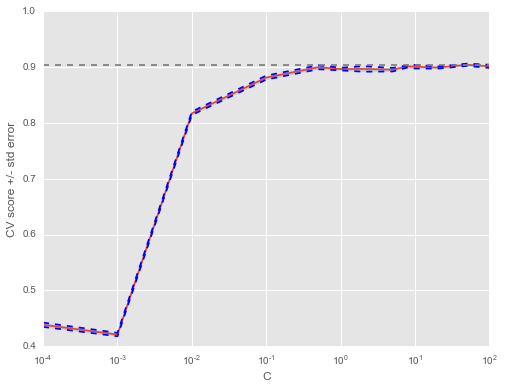

In [26]:
C = np.array([0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 5, 8, 10, 20, 50, 100])
scores = []
scoress = []
cv = cross_validation.ShuffleSplit(len(y), n_iter=5, test_size=0.2)
for c in C:
    clf = linear_model.LogisticRegression(C =c, penalty='l1', tol=0.01)
    scores_alpha = cross_validation.cross_val_score(clf, X, y, cv=cv, verbose = 1)
    scores.append(np.mean(scores_alpha))
    scoress.append(np.std(scores_alpha))

scores, scores_std = np.array(scores), np.array(scoress)

plt.figure().set_size_inches(8, 6)
plt.semilogx(C, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(5)

plt.semilogx(C, scores + std_error, 'b--')
plt.semilogx(C, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(C, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('C')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([C[0], C[-1]]) 
plt.show()

In [27]:
supportfun.classfication(linear_model.LogisticRegression(C =1, penalty='l1', tol=0.01), 5, False, X, y)

[0.8869104908565929, 0.8893166506256015, 0.9196342637151107, 0.89172281039461021, 0.91193455245428301]
accurancy:  0.9 0.013 

confusion_matrix:  [[ 0.898  0.101  0.001]
 [ 0.053  0.947  0.   ]
 [ 0.226  0.     0.774]] 



In [28]:
supportfun.classfication(RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0), 5, False, X, y)

[0.98893166506256014, 0.9898941289701636, 0.98941289701636193, 0.98219441770933591, 0.99278152069297398]
accurancy:  0.989 0.003 

confusion_matrix:  [[ 0.999  0.     0.001]
 [ 0.003  0.996  0.001]
 [ 0.059  0.002  0.939]] 



In [29]:
supportfun.classfication(AdaBoostClassifier(n_estimators=10), 5, False, X, y)

[0.57362848893166507, 0.54908565928777675, 0.56496631376323392, 0.5678537054860443, 0.56689124157844084]
accurancy:  0.564 0.008 

confusion_matrix:  [[ 1.     0.     0.   ]
 [ 1.     0.     0.   ]
 [ 0.104  0.     0.896]] 



In [30]:
supportfun.classfication(GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0), 5, False, X, y)

[0.97401347449470643, 0.98075072184793066, 0.98026948989412899, 0.9696823869104908, 0.98075072184793066]
accurancy:  0.977 0.004 

confusion_matrix:  [[ 0.985  0.015  0.   ]
 [ 0.     0.999  0.001]
 [ 0.1    0.005  0.895]] 



In [31]:
supportfun.classfication(DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0),  5, False, X, y)

[1.0, 1.0, 1.0, 0.99903753609239654, 0.99951876804619821]
accurancy:  1.0 0.0 

confusion_matrix:  [[ 1.     0.     0.   ]
 [ 0.     1.     0.   ]
 [ 0.001  0.     0.999]] 



In [32]:
supportfun.classfication(ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0), 5, False, X, y)

[0.95043310875842157, 0.94321462945139556, 0.96198267564966311, 0.95765158806544759, 0.95909528392685273]
accurancy:  0.954 0.007 

confusion_matrix:  [[ 0.985  0.011  0.004]
 [ 0.031  0.968  0.001]
 [ 0.166  0.002  0.832]] 



In [33]:
supportfun.classfication(GaussianNB(), 5, False, X, y)

[0.49951876804619827, 0.48748796920115495, 0.39990375360923963, 0.55582290664100098, 0.27285851780558229]
accurancy:  0.443 0.099 

confusion_matrix:  [[ 0.253  0.057  0.691]
 [ 0.197  0.479  0.324]
 [ 0.082  0.036  0.882]] 



In [34]:
supportfun.classfication(SVC(), 5, False, X, y)

[0.59287776708373441, 0.54186717998075073, 0.60587102983638108, 0.68142444658325307, 0.6809432146294514]
accurancy:  0.621 0.054 

confusion_matrix:  [[ 0.969  0.031  0.   ]
 [ 0.511  0.489  0.   ]
 [ 0.987  0.013  0.   ]] 



In [37]:
supportfun.classfication(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), 5, False, X, y)

[0.91337824831568815, 0.91289701636188647, 0.93022136669874878, 0.91819056785370545, 0.92011549566891238]
accurancy:  0.919 0.006 

confusion_matrix:  [[ 0.929  0.068  0.003]
 [ 0.072  0.928  0.   ]
 [ 0.133  0.001  0.867]] 



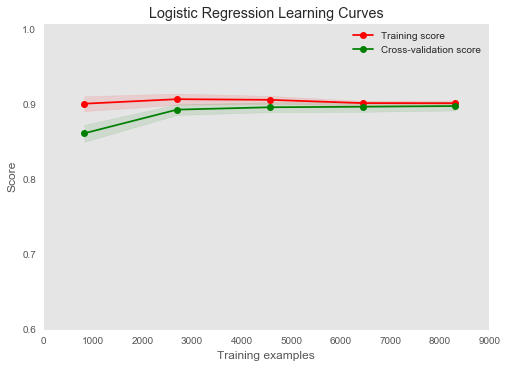

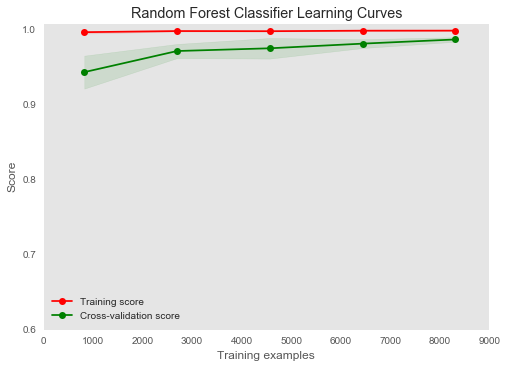

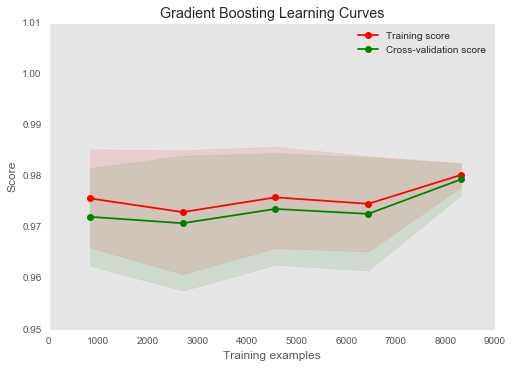

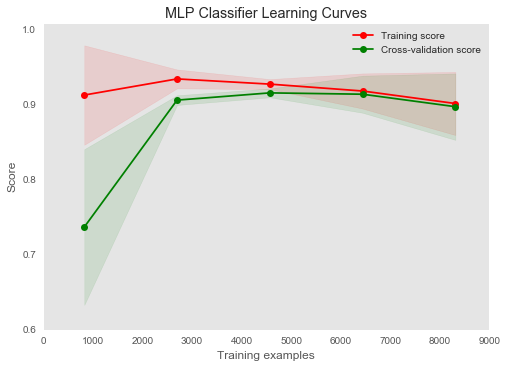

In [36]:
title = "Logistic Regression Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = linear_model.LogisticRegression(C =1, penalty='l1', tol=0.01)
supportfun.plot_learning_curve(estimator, title, X, y, ylim=(0.6, 1.01), cv=cv, n_jobs=4)

title = "Random Forest Classifier Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = RandomForestClassifier()
supportfun.plot_learning_curve(estimator, title, X, y, ylim=(0.6, 1.01), cv=cv, n_jobs=4)

title = "Gradient Boosting Learning Curves"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0)
supportfun.plot_learning_curve(estimator, title, X, y, ylim=(0.95, 1.01), cv=cv, n_jobs=4)

title = "MLP Classifier Learning Curves"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
supportfun.plot_learning_curve(estimator, title, X, y, ylim=(0.6, 1.01), cv=cv, n_jobs=4)


plt.show()

In [45]:
# feature importance plot
feature_imp = {u'hour':0.0429069, u'month':0.0053277, u'day':0.00727278,  u'week':0.00580396,  u'type_ratio':0.93868866}

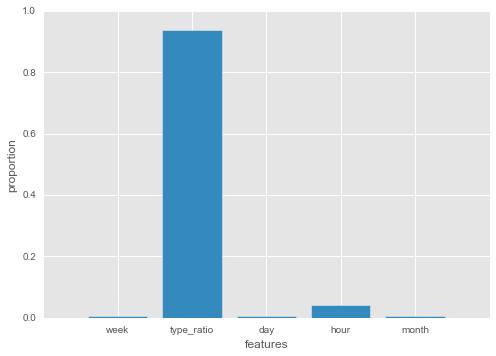

In [49]:
plt.bar(range(len(feature_imp)), feature_imp.values(), align='center')
plt.xticks(range(len(feature_imp)), feature_imp.keys())
plt.xlabel("features")
plt.ylabel("proportion")
plt.show()

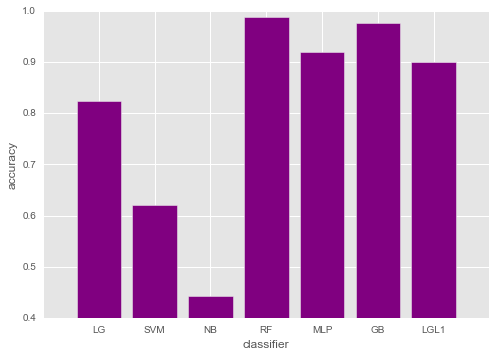

In [62]:
#accurancy of classifiers
acc = {}


acc['RF'] = 0.989
acc['GB'] = 0.977
acc['MLP'] = 0.919
acc['LGL1'] = 0.9
acc['LG'] = 0.824
acc['SVM'] = 0.621
acc['NB'] = 0.443
plt.bar(range(len(acc)), acc.values(), align='center', color = 'purple')
plt.xticks(range(len(acc)), acc.keys())
plt.xlabel("classifier")
plt.ylabel("accuracy")
plt.ylim(ymin = 0.4, ymax = 1.0)
plt.show()